In [1]:
import pandas
import numpy as np
from IPython.display import clear_output
import pyodbc
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import matplotlib
import seaborn
from mpl_toolkits.mplot3d import Axes3D

server = 'DT-InboundOps-EU.biz.electrolux.com' 
database = 'InboundDB_Test' 
username = 'InboundOps_test_ssrs' 
password = 'zz[3m6a<KJgO'  
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()
query = "SELECT[Purchase_Order],ref_month,ref_year,[SUPPLIER_SPARE_WH],[Plant],[Country],[Flow],[CompanyCode],[yearweek(GR_DATE)],[REQ_DEL_DATE],[GR_DATE],[Sched_qty],[sched_qty_2] as [sched_qty_w/c],[SumOfDeliveredQty],[KPI1]      ,round(cast([kpi1_1] as float) / cast([kpi1_2] as float), 5) as KPI1_wavg FROM [InboundDB_Test].[dbo].[WhPP_KPI_1]"
query2 = "select s1.Purchase_Order, s1.sum_sched_qty, s1.sum_delivered, round(cast(s1.sum_delivered as float)/cast(s1.sum_sched_qty as float), 5) as fulfillment, s1.avg_kpi1 from ( SELECT [Purchase_Order],sum([sched_qty_2]) as sum_sched_qty,sum([SumOfDeliveredQty]) sum_delivered ,sum(round(cast(SumOfDeliveredQty as float)/cast(sched_qty_2 as float), 5)) as fullfillment_a,avg([KPI1]) as avg_kpi1 FROM [InboundDB_Test].[dbo].[WhPP_KPI_1] where sched_qty_2 != 0 group by Purchase_Order) as s1 where s1.avg_kpi1 is not null"
kpi1data = pandas.read_sql(query, cnxn)
print(kpi1data.dtypes, kpi1data.shape[0])

kpi1_PO_group = pandas.read_sql(query2, cnxn)
print(kpi1_PO_group.dtypes, '\n')
kpi1_PO_group.shape[0]


Purchase_Order        object
ref_month             object
ref_year              object
SUPPLIER_SPARE_WH     object
Plant                 object
Country               object
Flow                  object
CompanyCode           object
yearweek(GR_DATE)     object
REQ_DEL_DATE          object
GR_DATE               object
Sched_qty              int64
sched_qty_w/c          int64
SumOfDeliveredQty      int64
KPI1                 float64
KPI1_wavg            float64
dtype: object 5866
Purchase_Order     object
sum_sched_qty       int64
sum_delivered       int64
fulfillment       float64
avg_kpi1            int64
dtype: object 



2388

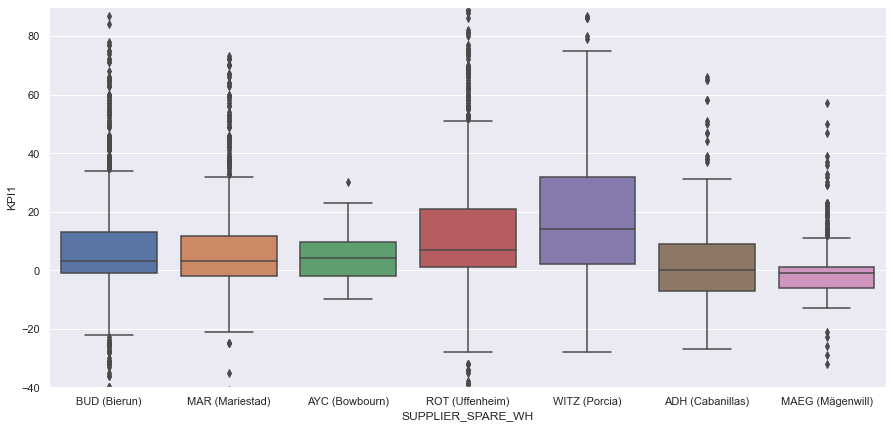

In [2]:
seaborn.set(rc = {'figure.figsize':(15,7)})

xa = kpi1data['SUPPLIER_SPARE_WH']
ya = kpi1data['KPI1']

seaborn.boxplot(data=kpi1data, y=ya, x=xa,
                width=0.8
               )
plt.ylim(-40,90)
plt.show()
#the main characteristics of the dataset:median, 3rd and 1st quartile, classified outliers

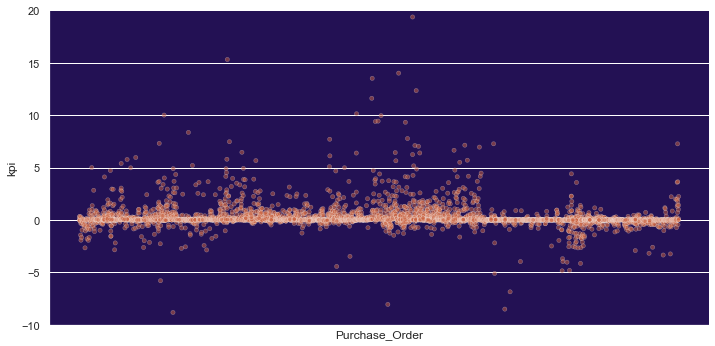

In [7]:
#purchase orders sorted ascending with KP1 value - visualizing the overall trend
#kpi1datas = kpi1data.sample(n=1000)
seaborn.relplot(data=kpi1data, y='KPI1_wavg', x='Purchase_Order',color='#cc6543',size=10,legend=0,aspect=2,alpha = 0.5)
ax = plt.gca()
#ax.axes.xaxis.set_visible(False)
ax.axes.xaxis.set_ticks([])
#plt.xlabel('Purchase Orders')
ax.set_facecolor('#231154')
plt.ylim(-10,20)
plt.ylabel("kpi")
#plt.savefig('C:\Users\OlszeBog\OneDrive - Electrolux\Pulpit\KPI1 purchase order distribution.png')
plt.show()

<AxesSubplot:xlabel='KPI1_wavg', ylabel='Density'>

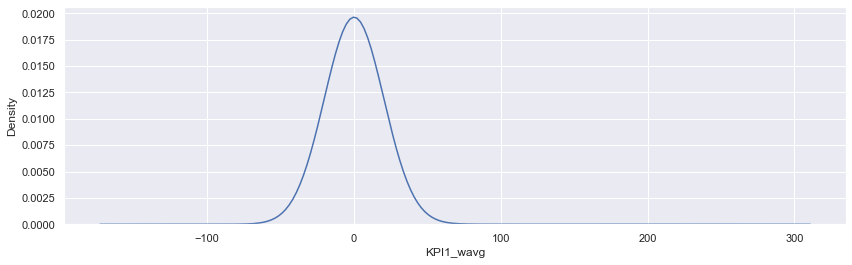

In [8]:
#showing the distribution
seaborn.set(rc = {'figure.figsize':(14,4)})
seaborn.kdeplot(x='KPI1_wavg', data=kpi1data,
               #gridsize=256,
                #cbar=0,
                bw_adjust=19
               )

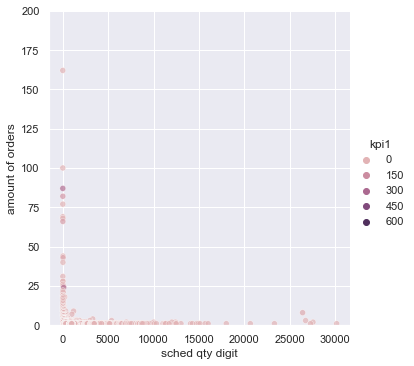

In [11]:
kpi1_cluster = kpi1data.groupby('sched_qty_w/c').agg({'sched_qty_w/c': 'count',
                                                      'KPI1_wavg': 'sum'})
kpi1_cluster.columns=( 'qty row count','kpi1')
kpi1_cluster['sched_qty_w/c'] = kpi1_cluster.index
kpi1_cluster.columns=( 'qty row count','kpi1', 'sched qty digit')
kpi1_cluster = kpi1_cluster.sort_values(by='qty row count', ascending =0)
kpi1_cluster = kpi1_cluster[kpi1_cluster['qty row count'] != 3938]#exclude the value for qty=0
#print(kpi1_cluster.head(67))
#kpi1_subset = kpi1_cluster.head(67)

seaborn.relplot(x='sched qty digit', y ='qty row count',
                data=kpi1_cluster, hue='kpi1', alpha=0.7)
#plt.xlabel('sched qty digit')
plt.ylabel('amount of orders')
plt.ylim(0,200)
plt.show()

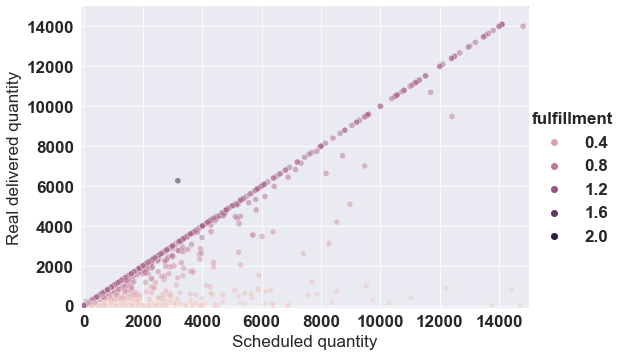

the correlation coefficient is:  0.955


In [24]:
kpi1_PO_group.head()
seaborn.relplot(data=kpi1_PO_group,
                x='sum_sched_qty',
                y='sum_delivered',
                hue='fulfillment',
                alpha=0.5,
               aspect=1.5)
plt.xlabel('Scheduled quantity')
plt.xlim(-100,15000)
plt.ylim(-100,15000)
plt.ylabel('Real delivered quantity')
plt.show()
print("the correlation coefficient is: ",
      round(kpi1_PO_group['sum_sched_qty'].corr(kpi1_PO_group['sum_delivered']),3))

            kpi
month          
1      0.423692
2      0.153333
3      1.840412
4      0.289989
5      0.238700
6      0.409199
7      0.591207
8      0.473929
9      0.367720
10     0.381239
11     0.248308
12     0.402267


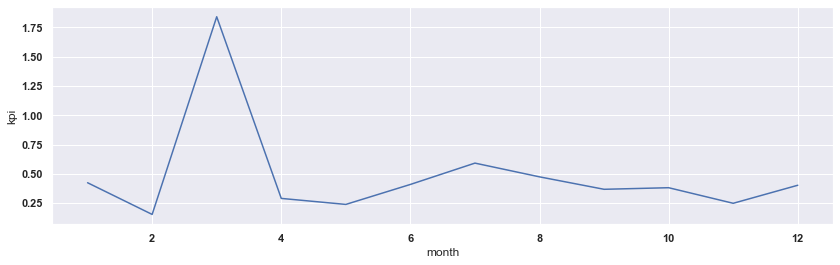

In [54]:
font = {'family' : 'normal','weight' : 'bold','size': 17}    
matplotlib.rc('font', **font)
seaborn.set_style("darkgrid")
kpi1data = kpi1data[kpi1data['SUPPLIER_SPARE_WH']=='ROT (Uffenheim)']

kpi1data['month'] = kpi1data['ref_month'].map({1:"January", 2:"February",3:"March",
                                                4:"April",5:"May",6:"June",7:"July",8:"August", 9:"September",
                                               10:"October", 11:"November", 12:"December"})
d={"kpi":kpi1data["KPI1_wavg"], "month":kpi1data["ref_month"]}
sdf = pandas.DataFrame(data = d)

sdf = pandas.DataFrame(sdf.groupby(["month"]).agg({"kpi": "mean"})).reset_index()
sdf['month'] = sdf['month'].astype(int)
sdf = sdf.set_index("month")
sdf = sdf.sort_index()
seaborn.lineplot(data=sdf, x="month", y="kpi", sort=False)
print(sdf)
plt.ylabel("kpi")

plt.show()
